# Import Libraries

In [19]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os

# NECESSARY LIBS FOR THRESHOLD PART
from skimage.filters import (
    threshold_niblack,
    threshold_sauvola,
    threshold_local,
    threshold_li,
    try_all_threshold,
)
from skimage.morphology import disk
from skimage.filters.rank import entropy 

# Read Image

In [2]:
img_path = r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Images\Yeni_V1.png"
image = cv2.imread(img_path)

In [3]:
def plot_image(image, width=800):

    if type(image) == str:
        image = cv2.imread(image)
    
    # Get the current dimensions of the image
    height, original_width = image.shape[:2]
    
    # Calculate the scaling factor and new dimensions while maintaining aspect ratio
    scaling_factor = width / original_width
    new_height = int(height * scaling_factor)
    new_dim = (width, new_height)
    
    # Rescale the image
    resized_image = cv2.resize(image, new_dim, interpolation=cv2.INTER_AREA)
    
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    
    # Adjust the figure size for a larger plot
    plt.figure(figsize=(image.shape[0] / 10, image.shape[1] / 10))  # Adjust scaling to make the image larger
    
    # Plot the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()


# Apply Masking To Images 

In [4]:
def save_regions_and_split(image, coordinates_list):
    """Apply a black mask to all parts of the image except the given coordinates regions."""
    height, width = image.shape[:2]
    images = []  # List to store the images after masking
    version = 0
    for (x1, y1), (x2, y2) in coordinates_list:
        # Ensure coordinates are within the image dimensions
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(width, x2), min(height, y2)
        
        # Create a black image (all zeros)
        masked_image = np.zeros_like(image)
        
        # Copy the region defined by the coordinates into the black image
        masked_image[y1:y2, x1:x2] = image[y1:y2, x1:x2]
        
        # Append the masked image to the list
        images.append(masked_image)
        cv2.imwrite( f"masked_image_V{version}.png", masked_image)
        version += 1
    return images

coordinates_list = [
    ((0, 0), (1300, 30)),        # Region 1
    ((5, 31), (251, 713)),        # Region 2
    ((260, 491), (1300, 730))     # Region 3
]

splits = save_regions_and_split(image, coordinates_list)

In [5]:
def apply_black_mask(image, top_left, bottom_right):
    """Apply a black mask to the selected region of the image."""
    x1, y1 = top_left
    x2, y2 = bottom_right
    
    # Ensure the coordinates are within the image dimensions
    height, width = image.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(width, x2), min(height, y2)
    print(y1,y2)
    # Apply the black mask (set the selected region to black)
    image[y1:y2, x1:x2] = 0  # Set the region to black (0)

    return image

# # Define the top-left and bottom-right coordinates of the region to mask
# top_left = (250, 30)       # Example top-left corner (x1, y1)
# bottom_right = (1300, 493)  # Example bottom-right corner (x2, y2)

# # Apply the black mask to the selected region
# masked_image = apply_black_mask(image, top_left, bottom_right)
# cv2.imwrite( "masked_image.png", masked_image)
# plot_image(masked_image)


# Apply Threshold

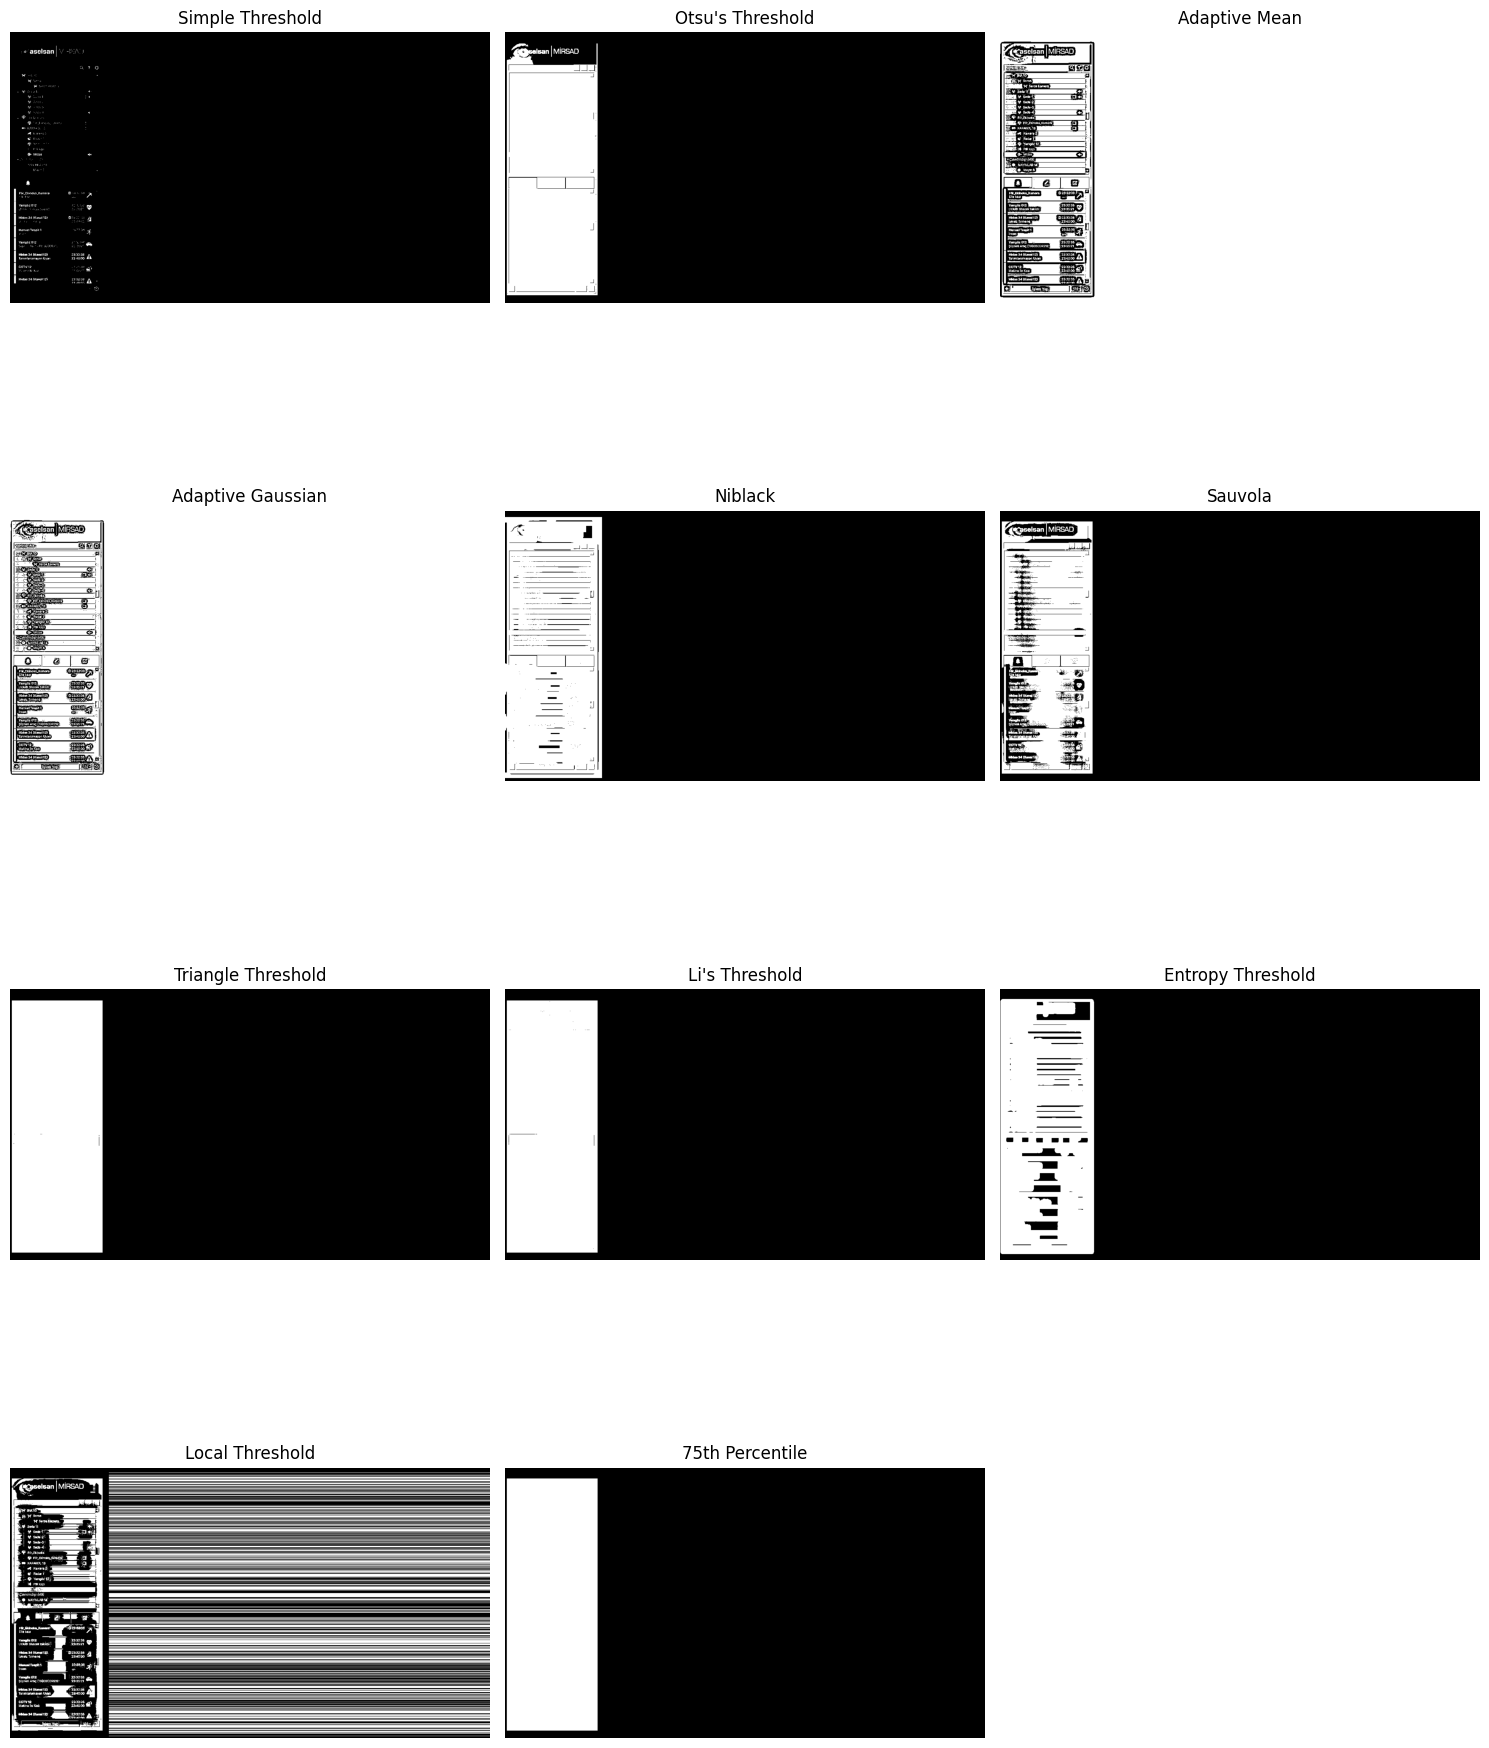

In [17]:
def apply_all_binarization_methods(image):
    """Apply all binarization methods from both implementations and plot results."""
    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    results = {}

    # 1. Simple Thresholding
    _, simple_thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    results["Simple Threshold"] = simple_thresh

    # 2. Otsu's Binarization
    _, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    results["Otsu's Threshold"] = otsu_thresh

    # 3. Adaptive Thresholding (Mean)
    adaptive_mean = cv2.adaptiveThreshold(
        gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2
    )
    results["Adaptive Mean"] = adaptive_mean

    # 4. Adaptive Thresholding (Gaussian)
    adaptive_gaussian = cv2.adaptiveThreshold(
        gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    results["Adaptive Gaussian"] = adaptive_gaussian

    # 5. Niblack's Method
    niblack_thresh = threshold_niblack(gray_image, window_size=25, k=0.8)
    niblack_binary = (gray_image > niblack_thresh).astype(np.uint8) * 255
    results["Niblack"] = niblack_binary

    # 6. Sauvola's Method
    sauvola_thresh = threshold_sauvola(gray_image, window_size=25)
    sauvola_binary = (gray_image > sauvola_thresh).astype(np.uint8) * 255
    results["Sauvola"] = sauvola_binary

    # 7. Triangle Threshold
    _, triangle_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    results["Triangle Threshold"] = triangle_thresh

    # 8. Li's Threshold
    li_thresh = threshold_li(gray_image)
    li_binary = (gray_image > li_thresh).astype(np.uint8) * 255
    results["Li's Threshold"] = li_binary

    # 9. Entropy-based Thresholding
    entropy_image = entropy(gray_image, disk(5))
    entropy_thresh = (entropy_image > np.mean(entropy_image)).astype(np.uint8) * 255
    results["Entropy Threshold"] = entropy_thresh

    # 10. Local Thresholding
    local_thresh = threshold_local(gray_image, block_size=35, method="mean")
    local_binary = (gray_image > local_thresh).astype(np.uint8) * 255
    results["Local Threshold"] = local_binary

    # 11. Percentile-based Thresholding
    percentile_thresh = np.percentile(gray_image, 75)
    percentile_binary = (gray_image > percentile_thresh).astype(np.uint8) * 255
    results["75th Percentile"] = percentile_binary

    # Plot results
    plot_binarization_results(results)


def plot_binarization_results(results):
    """Plot all the binarization results."""
    num_methods = len(results)
    cols = 3
    rows = (num_methods + cols - 1) // cols  # Calculate rows dynamically

    plt.figure(figsize=(15, 5 * rows))
    for idx, (method_name, binarized_image) in enumerate(results.items(), start=1):
        plt.subplot(rows, cols, idx)
        plt.imshow(binarized_image, cmap="gray")
        plt.title(method_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Example usage
image = cv2.imread(r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\masked_image_V1.png")
apply_all_binarization_methods(image)


In [37]:
import cv2
from skimage.filters import threshold_local
import os

def save_separate_binarizations(image, output_folder):
    """Apply specific binarization methods and save them as images."""
    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Save the Original Grayscale Image
    cv2.imwrite(os.path.join(output_folder, "original_gray.png"), gray_image)

    # Apply Adaptive Mean Thresholding
    adaptive_mean = cv2.adaptiveThreshold(
        gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2
    )
    cv2.imwrite(os.path.join(output_folder, "adaptive_mean.png"), adaptive_mean)

    # Apply Adaptive Gaussian Thresholding
    adaptive_gaussian = cv2.adaptiveThreshold(
        gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    cv2.imwrite(os.path.join(output_folder, "adaptive_gaussian.png"), adaptive_gaussian)

    # Apply Local Thresholding
    local_thresh = threshold_local(gray_image, block_size=35, method="mean")
    local_binary = (gray_image > local_thresh).astype("uint8") * 255
    cv2.imwrite(os.path.join(output_folder, "local_threshold.png"), local_binary)

    print(f"Images saved to {output_folder}")

# Example usage
image = cv2.imread(r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\masked_image_V1.png")
output_folder = r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Thresholded Images"  # Change to your desired output path
save_separate_binarizations(image, output_folder)


Images saved to C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Thresholded Images


In [44]:
import cv2
import os

def save_binary_thresholds(image, output_folder, thresholds=[50, 54, 57, 60, 70]):
    """Apply binary thresholding with multiple thresholds and save the results."""
    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Apply binary thresholding for each threshold value
    for threshold in thresholds:
        _, binary_thresh = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)
        filename = f"binary_threshold_{threshold}.png"
        cv2.imwrite(os.path.join(output_folder, filename), binary_thresh)

    print(f"Binary thresholded images saved to {output_folder} for thresholds: {thresholds}")

# Example usage
image = cv2.imread(r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\masked_image_V1.png")
output_folder = r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Thresholded Images\Binary Thresholds"  # Change to your desired output path
save_binary_thresholds(image, output_folder)


Binary thresholded images saved to C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Thresholded Images\Binary Thresholds for thresholds: [50, 54, 57, 60, 70]


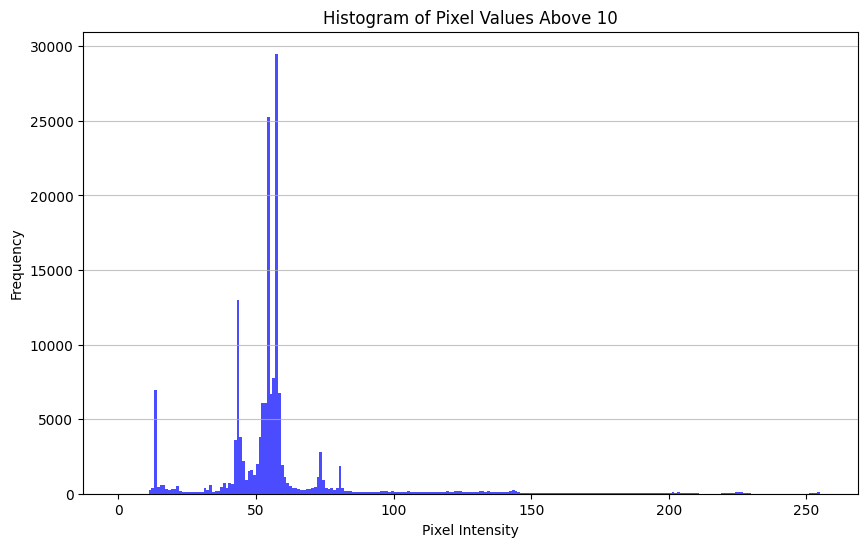

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def histogram_above_threshold(image, threshold=10):
    """Calculate and plot the histogram of pixel values above a specified threshold."""
    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Flatten the grayscale image to a 1D array
    pixel_values = gray_image.flatten()

    # Filter pixel values above the threshold
    filtered_pixels = pixel_values[pixel_values > threshold]

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_pixels, bins=256, range=(0, 256), color='blue', alpha=0.7)
    plt.title(f"Histogram of Pixel Values Above {threshold}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Example usage
image = cv2.imread(r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\masked_image_V1.png")
histogram_above_threshold(image, threshold=10)


# Noise Removal

In [55]:
import cv2
import numpy as np
import os

def noise_removal(image):
    """Remove noise from an image using morphological operations and blurring."""
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=10)
    image = cv2.erode(image, kernel, iterations=10)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return image

def process_png_images(input_folder, output_folder):
    """Apply noise removal to all PNG images in the input folder and save results."""
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # List all PNG files in the input folder
    png_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

    for file_name in png_files:
        # Load the image
        image_path = os.path.join(input_folder, file_name)
        image = cv2.imread(image_path)

        if image is not None:
            # Apply noise removal
            denoised_image = noise_removal(image)

            # Save the processed image in the output folder
            output_path = os.path.join(output_folder, file_name)
            cv2.imwrite(output_path, denoised_image)

    print(f"Processed {len(png_files)} PNG images and saved to '{output_folder}'.")

# Example usage
input_folder = r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Thresholded Images\Binary Thresholds"  # Replace with the path to your folder containing PNG files
output_folder = r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Noise Remove"  # Replace with the path to save processed images
process_png_images(input_folder, output_folder)


Processed 4 PNG images and saved to 'C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Noise Remove'.


# List All Images

In [56]:
def list_all_png_files(directory):
    """List all PNG files in the directory and its subdirectories."""
    png_files = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png'):
                full_path = os.path.join(root, file)
                png_files.append(full_path)

    return png_files

# Example usage
directory = r"C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess"  # Replace with your directory path
png_files = list_all_png_files(directory)

print("PNG Files Found:")
for file in png_files:
    print(file)


PNG Files Found:
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Original.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Masked Images\masked_image.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Masked Images\masked_image_V0.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Masked Images\masked_image_V1.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Masked Images\masked_image_V2.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Noise Remove\noise_removed_70.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Noise Remove\noise_removed_80.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Noise Remove\noise_removed_90.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Thresholded Images\adaptive_gaussian.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Thresholded Images\adaptive_mean.png
C:\Users\AZMI\Desktop\Izzet Ahmet\Kodlar\OCR\Preprocess\Thresholded Images\local_threshold.png
C: